# Smart Meter Signal Processing

### In this notebook, we'll apply some signal decomposition techniques on smart meter data readings. The goal is to be able to deconstruct kWh timeseries data into signals for individual devices.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(11, 4)})

### Some utilities

In [2]:
def differences(_df, diff_col, out_col):
    '''
    Calculates differences between diff_col in a row and the previous row and outputs the result to out_col in the row.
    Assumes out_col isn't defined.
    '''
    _df[out_col] = 0.0000
    _df.at[0, out_col] = 0.0
    for i, row in _df.iterrows():
        if i != 0:
            _df.at[i, out_col] = row[diff_col] - _df.iloc[i-1][diff_col]
    return _df

### Let's start by looking at the data we're working with.

In [3]:
df1 = pd.read_csv("../data/Metermind_export_-_3558a8b5-0138-4444-848e-abb632c56ff9.csv")
df2 = pd.read_csv("../data/Metermind_export_-_f9aee127-a39b-4f8c-aecb-dffb81d5e3f0.csv")

## Smart Meter Data

In [4]:
del df1["device_type"]

In [5]:
df1.head()

,id,meter,timestamp,electricity_received_tariff1,electricity_received_tariff2,electricity_delivered_tariff1,electricity_delivered_tariff2,electricity_tariff_indicator
0,48012,KA6U001660326812,2020-07-06 11:30:01,12674.378,8388.644,3192.424,7504.061,2
1,48013,KA6U001660326812,2020-07-06 11:45:05,12674.378,8388.644,3192.424,7504.300,2
2,48014,KA6U001660326812,2020-07-06 12:00:08,12674.378,8388.644,3192.424,7504.799,2
3,48015,KA6U001660326812,2020-07-06 12:15:01,12674.378,8388.644,3192.424,7505.058,2
4,48016,KA6U001660326812,2020-07-06 12:30:04,12674.378,8388.649,3192.424,7505.216,2


In [6]:
df1.tail()

,id,meter,timestamp,electricity_received_tariff1,electricity_received_tariff2,electricity_delivered_tariff1,electricity_delivered_tariff2,electricity_tariff_indicator
8774,56786,KA6U001660326812,2020-10-05 21:00:01,12955.178,8529.807,3453.465,8163.954,1
8775,56787,KA6U001660326812,2020-10-05 21:15:05,12955.448,8529.807,3453.465,8163.954,1
8776,56788,KA6U001660326812,2020-10-05 21:30:08,12955.550,8529.807,3453.465,8163.954,1
8777,56789,KA6U001660326812,2020-10-05 21:45:01,12955.644,8529.807,3453.465,8163.954,1
8778,56790,KA6U001660326812,2020-10-05 22:00:05,12955.733,8529.807,3453.465,8163.954,1


<AxesSubplot:xlabel='timestamp'>

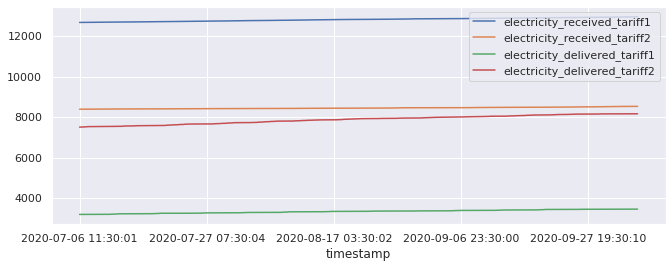

In [7]:
df1 = df1.set_index('timestamp')
num_cols = ['electricity_received_tariff1',
            'electricity_received_tariff2',
            'electricity_delivered_tariff1',
            'electricity_delivered_tariff2']
df1[num_cols] = df1[num_cols].astype(float)
df1[num_cols].plot()

In [8]:
df1 = df1.reset_index()

In [9]:
df1.head()

,timestamp,id,meter,electricity_received_tariff1,electricity_received_tariff2,electricity_delivered_tariff1,electricity_delivered_tariff2,electricity_tariff_indicator
0,2020-07-06 11:30:01,48012,KA6U001660326812,12674.378,8388.644,3192.424,7504.061,2
1,2020-07-06 11:45:05,48013,KA6U001660326812,12674.378,8388.644,3192.424,7504.300,2
2,2020-07-06 12:00:08,48014,KA6U001660326812,12674.378,8388.644,3192.424,7504.799,2
3,2020-07-06 12:15:01,48015,KA6U001660326812,12674.378,8388.644,3192.424,7505.058,2
4,2020-07-06 12:30:04,48016,KA6U001660326812,12674.378,8388.649,3192.424,7505.216,2


In [10]:
high_tariff = 0.4
low_tariff = 0.3

### Calculate kWh based on tarrifs

In [11]:
df1['elec_rcvd_1'] = 0.0
df1['elec_rcvd_2'] = 0.0
df1['elec_dlvd_1'] = 0.0
df1['elec_dlvd_2'] = 0.0
for i, row in df1.iterrows():
    if row['electricity_tariff_indicator'] == 1:
        df1.at[i, 'elec_rcvd_1'] = row['electricity_received_tariff1'] * low_tariff
        df1.at[i, 'elec_rcvd_2'] = row['electricity_received_tariff2'] * low_tariff
        df1.at[i, 'elec_dlvd_1'] = row['electricity_delivered_tariff1'] * low_tariff
        df1.at[i, 'elec_dlvd_2'] = row['electricity_delivered_tariff2'] * low_tariff
    else:
        df1.at[i, 'elec_rcvd_1'] = row['electricity_received_tariff1'] * high_tariff
        df1.at[i, 'elec_rcvd_2'] = row['electricity_received_tariff2'] * high_tariff
        df1.at[i, 'elec_dlvd_1'] = row['electricity_delivered_tariff1'] * high_tariff
        df1.at[i, 'elec_dlvd_2'] = row['electricity_delivered_tariff2'] * high_tariff

In [12]:
df1.head()

,timestamp,id,meter,electricity_received_tariff1,electricity_received_tariff2,electricity_delivered_tariff1,electricity_delivered_tariff2,electricity_tariff_indicator,elec_rcvd_1,elec_rcvd_2,elec_dlvd_1,elec_dlvd_2
0,2020-07-06 11:30:01,48012,KA6U001660326812,12674.378,8388.644,3192.424,7504.061,2,5069.7512,3355.4576,1276.9696,3001.6244
1,2020-07-06 11:45:05,48013,KA6U001660326812,12674.378,8388.644,3192.424,7504.300,2,5069.7512,3355.4576,1276.9696,3001.7200
2,2020-07-06 12:00:08,48014,KA6U001660326812,12674.378,8388.644,3192.424,7504.799,2,5069.7512,3355.4576,1276.9696,3001.9196
3,2020-07-06 12:15:01,48015,KA6U001660326812,12674.378,8388.644,3192.424,7505.058,2,5069.7512,3355.4576,1276.9696,3002.0232
4,2020-07-06 12:30:04,48016,KA6U001660326812,12674.378,8388.649,3192.424,7505.216,2,5069.7512,3355.4596,1276.9696,3002.0864


### Now get differences and plot

In [13]:
df1 = differences(df1, 'elec_rcvd_1', 'elec_rcvd_1_ts')
df1 = differences(df1, 'elec_rcvd_2', 'elec_rcvd_2_ts')
df1 = differences(df1, 'elec_dlvd_1', 'elec_dlvd_1_ts')
df1 = differences(df1, 'elec_dlvd_2', 'elec_dlvd_2_ts')

In [14]:
# df1.head(50)

<AxesSubplot:xlabel='timestamp'>

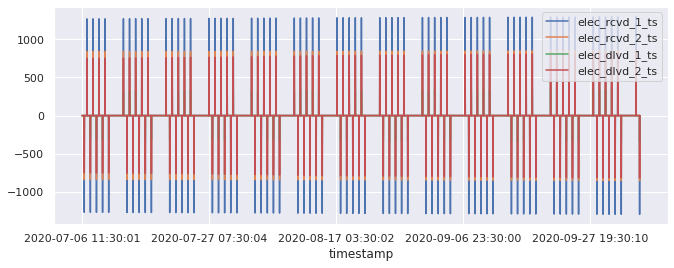

In [15]:
df1 = df1.set_index('timestamp')
num_cols = ['elec_rcvd_1_ts',
            'elec_rcvd_2_ts',
            'elec_dlvd_1_ts',
            'elec_dlvd_2_ts']
df1[num_cols] = df1[num_cols].astype(float)
df1[num_cols].plot()

### That's a bit strange... Let's try raw tariff differences

In [16]:
df1 = df1.reset_index()

In [17]:
df1 = differences(df1, 'electricity_received_tariff1', 'elec_rcvd_1_ts')
df1 = differences(df1, 'electricity_received_tariff2', 'elec_rcvd_2_ts')
df1 = differences(df1, 'electricity_delivered_tariff1', 'elec_dlvd_1_ts')
df1 = differences(df1, 'electricity_delivered_tariff2', 'elec_dlvd_2_ts')

<AxesSubplot:xlabel='timestamp'>

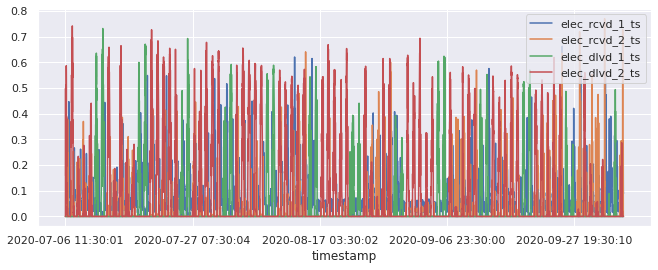

In [18]:
df1 = df1.set_index('timestamp')
num_cols = ['elec_rcvd_1_ts',
            'elec_rcvd_2_ts',
            'elec_dlvd_1_ts',
            'elec_dlvd_2_ts']
df1[num_cols] = df1[num_cols].astype(float)
df1[num_cols].plot()

### That's better, now let's jump into some decomposition.

## Gas Meter Data (not used)

In [19]:
df2.shape

(4392, 6)

In [20]:
df2 = df2.drop([i for i in range(0,df2.shape[0], 2)]).reset_index(drop=True)

In [21]:
df2.head()

,id,mbusdevice,meter,timestamp,reading,device_type
0,11998,2.810154e+16,KA6U001660326812,2020-07-06 12:00:00,12683.872,3
1,11999,2.810154e+16,KA6U001660326812,2020-07-06 13:00:00,12683.879,3
2,12000,2.810154e+16,KA6U001660326812,2020-07-06 14:00:00,12683.884,3
3,12001,2.810154e+16,KA6U001660326812,2020-07-06 15:00:00,12683.893,3
4,12002,2.810154e+16,KA6U001660326812,2020-07-06 16:00:00,12683.896,3


<AxesSubplot:xlabel='timestamp'>

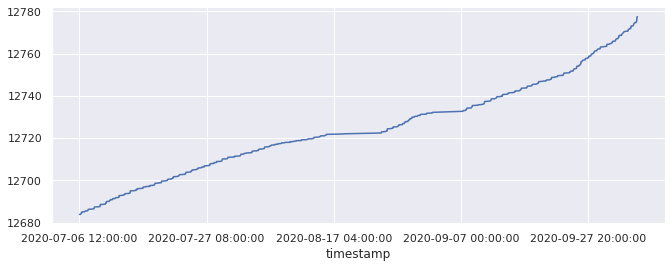

In [22]:
df2 = df2.set_index('timestamp')
df2['reading'] = df2['reading'].astype(float)
df2['reading'].plot()

In [23]:
df2 = differences(df2.reset_index(), 'reading', 'usage')

In [24]:
df2.head()

,timestamp,id,mbusdevice,meter,reading,device_type,usage
0,2020-07-06 12:00:00,11998,2.810154e+16,KA6U001660326812,12683.872,3,0.000
1,2020-07-06 13:00:00,11999,2.810154e+16,KA6U001660326812,12683.879,3,0.007
2,2020-07-06 14:00:00,12000,2.810154e+16,KA6U001660326812,12683.884,3,0.005
3,2020-07-06 15:00:00,12001,2.810154e+16,KA6U001660326812,12683.893,3,0.009
4,2020-07-06 16:00:00,12002,2.810154e+16,KA6U001660326812,12683.896,3,0.003


<AxesSubplot:xlabel='timestamp'>

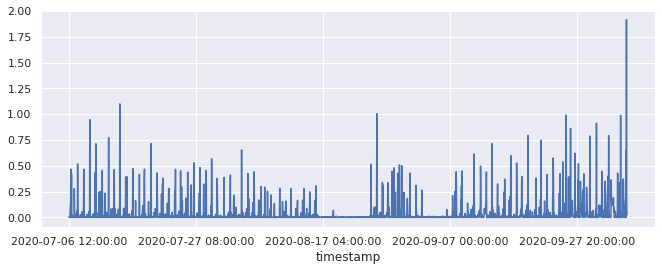

In [25]:
df2 = df2.set_index('timestamp')
# df2['reading'] = df2['usage'].astype(float)
df2['usage'].plot()